In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

## Constants

In [3]:
vocab_size = 257
embedding_size = 5
hidden_units = 10
batch_size = 5
GO = 256
END = 257
image_dim = 28
image_grid_flat = 784
D_hidden_1 = 100
D_out = 1
generator_length = tf.constant(image_grid_flat, dtype=tf.int32, name="length")

## Generator

In [4]:
with tf.name_scope("generator_variables"):
    embeddings = tf.get_variable("g_embeddings", shape=[vocab_size, embedding_size], dtype=tf.float32, 
                                 initializer=tf.random_uniform_initializer)
    go_time_slice = tf.ones([batch_size], dtype=tf.int32) * 256
    end_time_slice = tf.ones([batch_size], dtype=tf.int32) * 257
    go_embedding = tf.nn.embedding_lookup(embeddings, go_time_slice)
    end_embedding = tf.nn.embedding_lookup(embeddings, end_time_slice)

    W = tf.Variable(tf.random_uniform([hidden_units, vocab_size], -1.0, 1.0), name="W")
    b = tf.Variable(tf.random_uniform([vocab_size]), name="b")

    cells = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
    init_state = cells.zero_state(batch_size, dtype=tf.float32)

with tf.name_scope("generator_loop_function"):
    def loop_initial():
        initial_elements_finished = (0 >= generator_length)
        initial_input = go_embedding
        initial_cell_state = init_state
        initial_cell_output = None
        initial_loop_state = None

        return (initial_elements_finished,
               initial_input,
               initial_cell_state, initial_cell_output,
               initial_loop_state)

    def loop_transition(time, previous_output, previous_state, previous_loop_state):
        def get_next_input():
            output_logits = tf.matmul(previous_output, W) + b
            prediction = tf.argmax(output_logits, axis = 1)
            next_input = tf.nn.embedding_lookup(embeddings, prediction)
            return next_input

        elements_finished = (time >= generator_length)
        finished = tf.reduce_all(elements_finished)
        ninput = tf.cond(finished, lambda: end_embedding, get_next_input)
        state = previous_state
        output = previous_output
        loop_state = None

        return (finished, ninput, state, output, loop_state)

    def loop_fn(time, poutput, pstate, ploop):
        if pstate is None:
            return loop_initial()
        else:
            return loop_transition(time, poutput, pstate, ploop)

In [5]:
with tf.name_scope("Convolutions"):
    def conv2d(x, W, n = "conv"):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME", name=n)

    conv_weights = {"weights" : tf.Variable(tf.random_uniform([3, 3, 10, 1], -1.0, 1.0), name="cweights"),
                   "biases" : tf.Variable(tf.random_uniform([1], -1.0, 1.0), name="cbiases")}

In [6]:
with tf.name_scope("generator_main"):
    def generator():
        outputs_ta, _, _ = tf.nn.raw_rnn(cells, loop_fn)

        generator_outputs = outputs_ta.stack()
        generator_outputs = tf.transpose(generator_outputs, (1, 0, 2))
        generator_outputs = tf.reshape(generator_outputs, (batch_size, 28, 28, hidden_units))
        final_image = tf.nn.relu(conv2d(generator_outputs, conv_weights['weights']) + conv_weights["biases"])
        final_image = tf.reshape(final_image, (-1, generator_length))
        return final_image


## Discriminator

In [7]:
with tf.name_scope("discriminator_variables"):
    x_real = tf.placeholder("float", [None, image_grid_flat])
    
    D_W1 = tf.Variable(tf.random_uniform([image_grid_flat, D_hidden_1], -1.0, 1.0))
    D_b1 = tf.Variable(tf.random_uniform([D_hidden_1], -1.0, 1.0))
    
    D_W2 = tf.Variable(tf.random_uniform([D_hidden_1, D_out], -1.0, 1.0))
    D_b2 = tf.Variable(tf.random_uniform([D_out], -1.0, 1.0))
    
    theta_D = [D_W1, D_W2, D_b1, D_b2]

with tf.name_scope("discriminator_main"):
    def discriminator(x):
        l1 = tf.nn.relu(tf.matmul(tf.cast(x, dtype=tf.float32), D_W1) + D_b1)
        logits = tf.matmul(l1, D_W2) + D_b2
        output = tf.nn.sigmoid(logits)
        
        return output, logits

## Loss Definitions

In [8]:
with tf.name_scope("running_GAN"):
    sampled = generator()
    D_real, D_real_logits = discriminator(x_real)
    D_fake, D_fake_logits = discriminator(sampled)

with tf.name_scope("discriminator_loss"):
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)), name="D_real_loss")
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)), name="D_fake_loss")

with tf.name_scope("generator_loss"):
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)), name="G_loss")

with tf.name_scope("Get_trainable_Variables"):
    gen_var = [var for var in tf.trainable_variables() if "discriminator" not in var.name]
    dis_var = [var for var in tf.trainable_variables() if "discriminator" in var.name]

In [9]:
with tf.name_scope("Train_op"):
    D_real_solver = tf.train.AdamOptimizer().minimize(D_loss_real, var_list = dis_var)
    D_fake_solver = tf.train.AdamOptimizer().minimize(D_loss_fake, var_list = dis_var)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list = gen_var)

In [10]:
sess.run(tf.global_variables_initializer())

## Training

In [19]:
print(sess.run([D_fake]))
sess.run([G_solver])
print(sess.run([D_fake]))

[array([[ 0.00585586],
       [ 0.00585586],
       [ 0.00585586],
       [ 0.00585586],
       [ 0.00585586]], dtype=float32)]
[array([[ 0.00859304],
       [ 0.00859304],
       [ 0.00859304],
       [ 0.00859304],
       [ 0.00859304]], dtype=float32)]


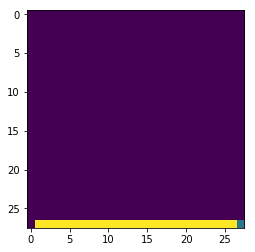

In [20]:
ans = sess.run(sampled)
plt.imshow(ans[1].reshape((28, 28)))

## Session Close

In [21]:
sess.close()

## Saving graph

In [14]:
#g = tf.get_default_graph()
#tf.summary.FileWriter("log", g).close()